In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords, wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download necessary data
nltk.download('stopwords')
nltk.download('wordnet')

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Function for text augmentation (Synonym Replacement)
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()

    # Create a set of words already replaced to avoid redundant replacements
    replaced_words = set()

    for _ in range(min(2, len(words))):  # Replace up to 2 words
        # Select a word that hasn't been replaced yet
        word = random.choice([w for w in words if w not in replaced_words])
        syns = wordnet.synsets(word)

        if syns:
            synonym = syns[0].lemmas()[0].name()

            # Replace all occurrences of the word with the synonym
            for i in range(len(new_words)):
                if new_words[i] == word:
                    new_words[i] = synonym

            # Add the word to the replaced words set
            replaced_words.add(word)

    return ' '.join(new_words)

In [ ]:
# Load csv file
file_path = "/content/dreaddit_StressAnalysis - Sheet1.csv"
df = pd.read_csv(file_path)
df.head()
df.shape()

TypeError: 'tuple' object is not callable

In [ ]:
# Assuming dataset has columns: 'text' (input) and 'label' (output)
df['text'] = df['text'].astype(str).apply(clean_text)

In [ ]:
# Apply data augmentation
df['augmented_text'] = df['text'].apply(synonym_replacement)
df = pd.concat([df[['text', 'label']], df[['augmented_text', 'label']].rename(columns={'augmented_text': 'text'})])


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
max_len = 100  # Set max sequence length
X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [ ]:
# Build Improved LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Use softmax if more than 2 labels
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# Build GRU Model
def build_gru_model():
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=max_len),
        Bidirectional(GRU(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(GRU(32)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Use softmax if more than 2 labels
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Train and evaluate both models function with visualization
def train_and_evaluate(model):
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=6,
                        batch_size=32,
                        verbose=1)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nModel Performance:\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

    return history

In [ ]:
# Visualization function for training history and confusion matrix
def visualize_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Confusion Matrix Visualization Function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show()

Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 501ms/step - accuracy: 0.5402 - loss: 0.7952 - val_accuracy: 0.5350 - val_loss: 0.6859
Epoch 2/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.8675 - loss: 0.3561 - val_accuracy: 0.5350 - val_loss: 0.6696
Epoch 3/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9644 - loss: 0.1323 - val_accuracy: 0.6014 - val_loss: 0.6081
Epoch 4/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9799 - loss: 0.0729 - val_accuracy: 0.6434 - val_loss: 0.5742
Epoch 5/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9921 - loss: 0.0355 - val_accuracy: 0.7483 - val_loss: 0.5209
Epoch 6/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9973 - loss: 0.0187 - val_accuracy: 0.8671 - val_loss: 0.3873
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step

Model Performance:
Accuracy: 0.8671 | Precision: 0.8108 | Recall: 0.9804 | F1-score: 0.8876


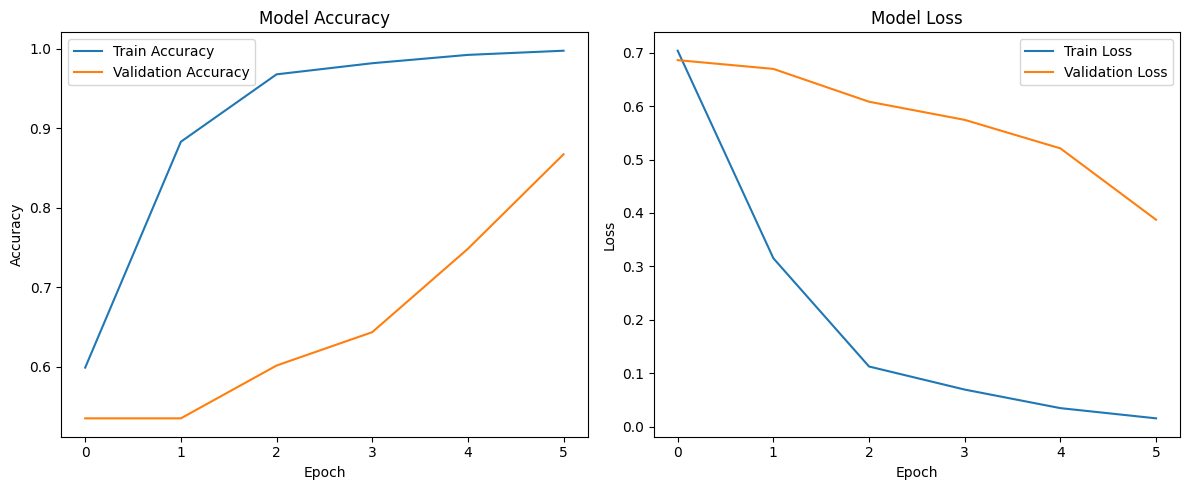

In [ ]:
# Train LSTM Model and visualize results
print("Training LSTM Model...")
lstm_model = build_lstm_model()
lstm_history = train_and_evaluate(lstm_model)
visualize_results(lstm_history)

Training GRU Model...
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 301ms/step - accuracy: 0.5293 - loss: 0.8198 - val_accuracy: 0.5350 - val_loss: 0.6882
Epoch 2/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7436 - loss: 0.5326 - val_accuracy: 0.5350 - val_loss: 0.6809
Epoch 3/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - accuracy: 0.8766 - loss: 0.2932 - val_accuracy: 0.5385 - val_loss: 0.6509
Epoch 4/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.9727 - loss: 0.1181 - val_accuracy: 0.6329 - val_loss: 0.5749
Epoch 5/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.9929 - loss: 0.0525 - val_accuracy: 0.7378 - val_loss: 0.4843
Epoch 6/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.8217 - val_loss: 0.4006
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step

Model Performance:
Accuracy: 0.8217 | Precision: 0.7500 | Recall: 1.0000 | F1-score: 0.8571


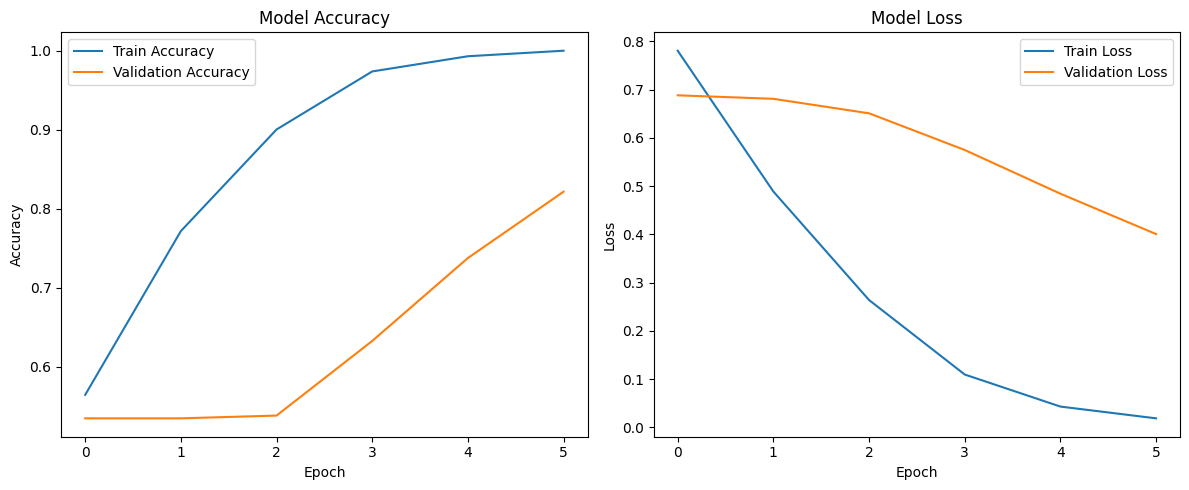

In [ ]:
# Train GRU Model and visualize results
print("Training GRU Model...")
gru_model = build_gru_model()
gru_history = train_and_evaluate(gru_model)
visualize_results(gru_history)

In [ ]:
# Save the models after training
lstm_model.save("mental_health_lstm_model.h5")
gru_model.save("mental_health_gru_model.h5")


In [ ]:
# Function to predict new text using selected model (default is GRU)
def predict_mental_health(text):
    cleaned_text = clean_text(text)

    # Sentiment Analysis using TextBlob
    sentiment_score = TextBlob(cleaned_text).sentiment.polarity

    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_len)

    prediction_lstm = lstm_model.predict(padded_seq)[0][0]
    prediction_gru = gru_model.predict(padded_seq)[0][0]

    concern_lstm = "Mental Health Concern" if prediction_lstm > 0.5 else "No Concern"
    concern_gru = "Mental Health Concern" if prediction_gru > 0.5 else "No Concern"

    sentiment = "Negative" if sentiment_score < -0.2 else "Neutral" if sentiment_score < 0.2 else "Positive"

    return (f"LSTM Prediction: {concern_lstm} | GRU Prediction: {concern_gru} | "
            f"Sentiment: {sentiment} (Score: {sentiment_score:.2f})")

In [ ]:
# Interactive user input with model selection option removed for simplicity.
while True:
    user_text = input("\nEnter a mental health-related text (or type 'exit' to quit): ")

    if user_text.lower() == "exit":
        break

    print(predict_mental_health(user_text))


Enter a mental health-related text (or type 'exit' to quit): im happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
LSTM Prediction: Mental Health Concern | GRU Prediction: Mental Health Concern | Sentiment: Positive (Score: 0.80)

Enter a mental health-related text (or type 'exit' to quit): im sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM Prediction: Mental Health Concern | GRU Prediction: Mental Health Concern | Sentiment: Negative (Score: -0.50)

Enter a mental health-related text (or type 'exit' to quit): exit
